### Importing Libraries

In [1]:
seed = 17
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from scipy import stats
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
import pickle

### Loading Data

In [2]:
Xs = []
ys = []

Xs.append(pd.read_csv("../data/credit_X.csv"))
Xs.append(pd.read_csv("../data/raisin_X.csv"))
Xs.append(pd.read_csv("../data/alzheimer_X.csv"))
Xs.append(pd.read_csv("../data/salary_X.csv"))

ys.append(pd.read_csv("../data/credit_y.csv").iloc[:, 0])
ys.append(pd.read_csv("../data/raisin_y.csv").iloc[:, 0])
ys.append(pd.read_csv("../data/alzheimer_y.csv").iloc[:, 0])
ys.append(pd.read_csv("../data/salary_y.csv").iloc[:, 0])

### Functions

In [3]:
def tune_with_random_search(model, search_grid, n_iter, scoring):
    opt_results = []
    for i in range(4):
        # in my case works faster with n_jobs=-1
        opt = RandomizedSearchCV(model, search_grid, n_iter=n_iter, cv=5, scoring=scoring, random_state=seed, n_jobs=-1)
        opt_results.append(opt.fit(Xs[i], ys[i]))
    return opt_results

def tune_with_bayes_search(model, search_grid, n_iter, scoring):
    opt_results = []
    for i in range(4):
        opt = BayesSearchCV(model, search_grid, n_iter=n_iter, cv=5, scoring=scoring, random_state=seed)
        opt_results.append(opt.fit(Xs[i], ys[i]))
    return opt_results

def get_tunability(model_class, default_grid, tuned_grids, scoring):
    tunabilities = []
    for i in range(4):
        # Replace key "model__hiperparameter" to key "hiperparameter"
        cleaned_params = {key.replace('gbc__', ''): value for key, value in tuned_grids[i].best_params_.items()}
        pipe_default = Pipeline(steps=[
            ("preprocessing", MinMaxScaler()),
            ("model", model_class(**default_grid))
        ])
        pipe_tuned = Pipeline(steps=[
            ("preprocessing", MinMaxScaler()),
            ("model", model_class(**cleaned_params))
        ])

        default_score = cross_val_score(pipe_default, Xs[i], ys[i], cv=5, scoring=scoring, n_jobs=-1).mean()
        tuned_score = cross_val_score(pipe_tuned, Xs[i], ys[i], cv=5, scoring=scoring, n_jobs=-1).mean()
        tunabilities.append(tuned_score - default_score)
    return tunabilities

def save_result(result, path_to_save):
    with open(path_to_save, 'wb') as file:
        pickle.dump(result, file)

def load_result(path):
    with open(path, 'rb') as file:
        return pickle.load(file)
    
def get_deafult_score(model_class, default_grid, scoring):
    default_scores = []
    for i in range(4):
        pipe_default = Pipeline(steps=[
            ("preprocessing", MinMaxScaler()),
            ("model", model_class(**default_grid))
        ])
        default_score = cross_val_score(pipe_default, Xs[i], ys[i], cv=5, scoring=scoring, n_jobs=-1).mean()
        default_scores.append(default_score)
    return default_scores

In [4]:
pipe_gbc = Pipeline(
    [
        ('scaler', MinMaxScaler()),
        ('gbc', GradientBoostingClassifier())
    ]

)

search_grid={
    'gbc__n_estimators': [i for i in range(50, 1701,1)],
    'gbc__learning_rate': np.linspace(0.01, 0.2, 5),
    'gbc__max_depth': np.arange(3, 11),
    'gbc__min_samples_leaf': [i/1000 for i in range(5,201,5)],
    'gbc__subsample': [i/10 for i in range(1,11)],
    'gbc__max_features': [None, 'sqrt', 'log2'],
    'gbc__random_state': [seed]
}

In [5]:
%%time

gbc_opt_results_rs = tune_with_random_search(pipe_gbc, search_grid,100, 'roc_auc')

CPU times: user 8.9 s, sys: 903 ms, total: 9.8 s
Wall time: 7min 11s


In [20]:
save_result(gbc_opt_results_rs,'./saved_results/gbc_opt_results_rs.pkl')

In [21]:
gbc_opt_results_rs=load_result('./saved_results/gbc_opt_results_rs.pkl')

In [24]:
for i in range(4):
    print(gbc_opt_results_rs[i].best_params_)

{'gbc__subsample': 0.3, 'gbc__random_state': 17, 'gbc__n_estimators': 63, 'gbc__min_samples_leaf': 0.13, 'gbc__max_features': None, 'gbc__max_depth': 5, 'gbc__learning_rate': 0.105}
{'gbc__subsample': 0.9, 'gbc__random_state': 17, 'gbc__n_estimators': 288, 'gbc__min_samples_leaf': 0.08, 'gbc__max_features': None, 'gbc__max_depth': 6, 'gbc__learning_rate': 0.01}
{'gbc__subsample': 0.7, 'gbc__random_state': 17, 'gbc__n_estimators': 596, 'gbc__min_samples_leaf': 0.025, 'gbc__max_features': None, 'gbc__max_depth': 6, 'gbc__learning_rate': 0.15250000000000002}
{'gbc__subsample': 0.8, 'gbc__random_state': 17, 'gbc__n_estimators': 1344, 'gbc__min_samples_leaf': 0.035, 'gbc__max_features': None, 'gbc__max_depth': 3, 'gbc__learning_rate': 0.01}


In [13]:
gbc_tunabilities_rs = get_tunability(GradientBoostingClassifier, {'random_state': seed}, gbc_opt_results_rs, 'roc_auc')
gbc_tunabilities_rs

[0.010470970915049782,
 0.004209876543210034,
 0.005514727492184401,
 -0.005745324384787476]

### Bayesian Optimization

In [8]:
pipe_gbc = Pipeline(
    [
        ('scaler', MinMaxScaler()),
        ('gbc', GradientBoostingClassifier())
    ]

)

search_grid={
    'gbc__n_estimators': Integer(50, 1700),
    'gbc__learning_rate': Real(0.01, 0.2),
    'gbc__max_depth': Integer(3, 30),
    'gbc__min_samples_leaf': Real(5/1000,200/1000),
    'gbc__subsample': Real(0.01,1.0),
    'gbc__max_features': Categorical([None, 'sqrt', 'log2']),
    'gbc__random_state': Categorical([seed])
}

In [9]:
%%time

gbc_opt_results_bs = tune_with_bayes_search(pipe_gbc, search_grid,100, 'roc_auc')

/opt/homebrew/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.01, 3, 'log2', 0.2, 50, 17, 1.0] before, using random point [0.12255715975596193, 7, 'sqrt', 0.1146100767252543, 1565, 17, 0.3695321085627623]
  warnings.warn(


CPU times: user 1h 44min 13s, sys: 44min 54s, total: 2h 29min 7s
Wall time: 56min 4s


In [19]:
save_result(gbc_opt_results_bs,'./saved_results/gbc_opt_results_bs.pkl')

In [22]:
gbc_opt_results_bs=load_result('./saved_results/gbc_opt_results_bs.pkl')

In [23]:
for i in range(4):
    print(gbc_opt_results_bs[i].best_params_)

OrderedDict([('gbc__learning_rate', 0.01), ('gbc__max_depth', 3), ('gbc__max_features', 'sqrt'), ('gbc__min_samples_leaf', 0.2), ('gbc__n_estimators', 50), ('gbc__random_state', 17), ('gbc__subsample', 0.5595882699882295)])
OrderedDict([('gbc__learning_rate', 0.06854372800806469), ('gbc__max_depth', 3), ('gbc__max_features', None), ('gbc__min_samples_leaf', 0.005), ('gbc__n_estimators', 50), ('gbc__random_state', 17), ('gbc__subsample', 0.747570345453331)])
OrderedDict([('gbc__learning_rate', 0.01), ('gbc__max_depth', 30), ('gbc__max_features', None), ('gbc__min_samples_leaf', 0.005), ('gbc__n_estimators', 1700), ('gbc__random_state', 17), ('gbc__subsample', 0.6991414426274039)])
OrderedDict([('gbc__learning_rate', 0.10544362863443772), ('gbc__max_depth', 3), ('gbc__max_features', 'log2'), ('gbc__min_samples_leaf', 0.005), ('gbc__n_estimators', 50), ('gbc__random_state', 17), ('gbc__subsample', 0.6663342032840008)])


In [15]:
gbc_tunabilities_bs = get_tunability(GradientBoostingClassifier, {'random_state': seed}, gbc_opt_results_bs, 'roc_auc')

gbc_tunabilities_bs

[0.021164667751838784,
 0.00628395061728404,
 0.008401481360987506,
 0.0009279063034609569]

### Plots

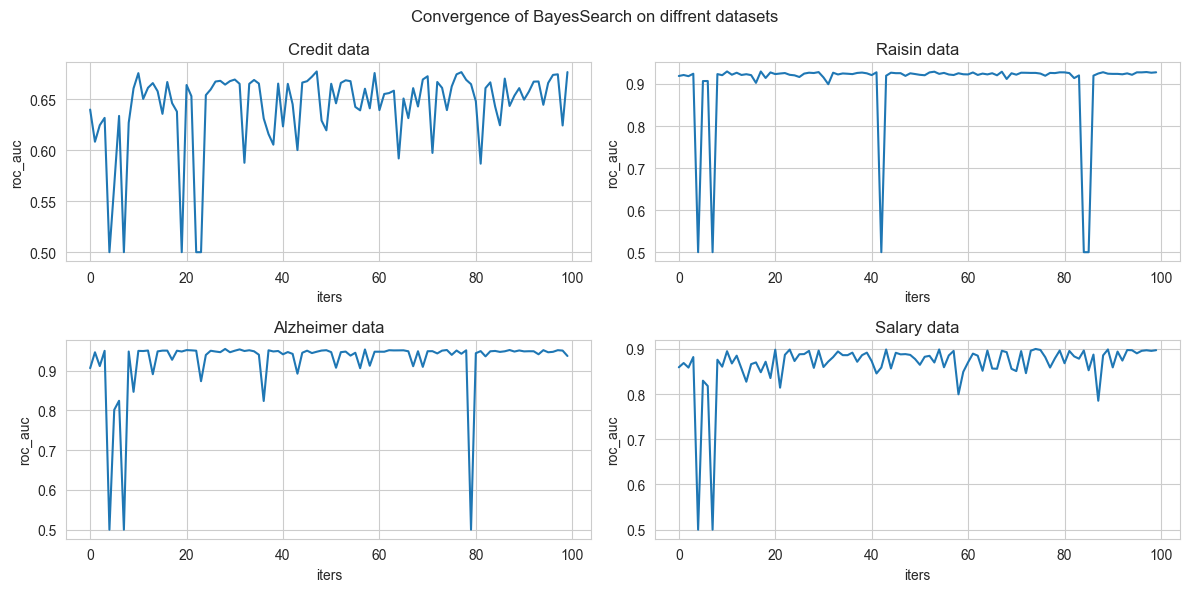

In [25]:
titles = ["Credit data", "Raisin data", "Alzheimer data", "Salary data"]
fig, axs = plt.subplots(2, 2, figsize = (12, 6))
axs = axs.flatten()
fig.suptitle("Convergence of BayesSearch on diffrent datasets")
for i in range(4):
    axs[i].plot(gbc_opt_results_bs[i].cv_results_["mean_test_score"])
    axs[i].set_title(titles[i])
    axs[i].set_xlabel("iters")
    axs[i].set_ylabel("roc_auc")
plt.tight_layout()
plt.show()

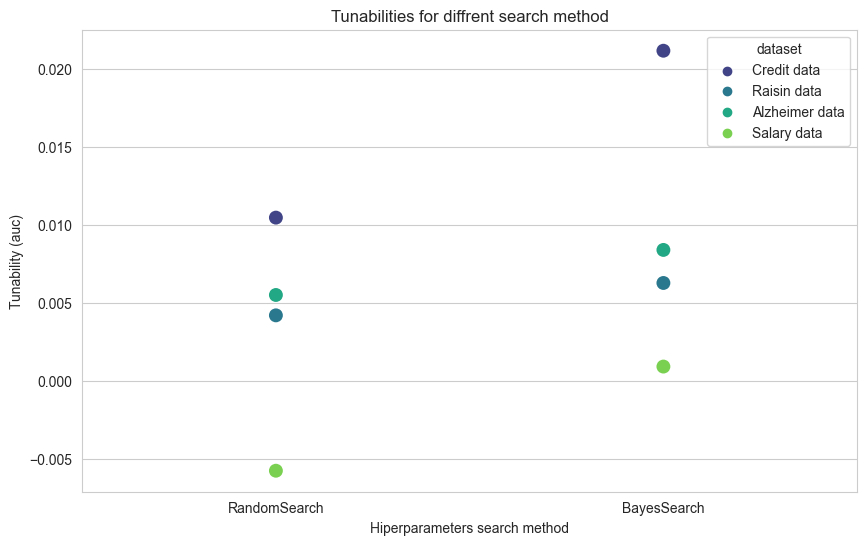

In [26]:
data = {
    'tunability': gbc_tunabilities_rs + gbc_tunabilities_bs,
    'alg': ["RandomSearch"] *  4 + ["BayesSearch"] * 4,
    'dataset': ["Credit data", "Raisin data", "Alzheimer data", "Salary data"]*2
}
df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
sns.swarmplot(x='alg', y='tunability', hue='dataset', data=df, palette='viridis', size=10)

plt.title('Tunabilities for diffrent search method')
plt.xlabel('Hiperparameters search method')
plt.ylabel('Tunability (auc)')
plt.show()

### Histogram of metric value differences

In [27]:
default_score = get_deafult_score(GradientBoostingClassifier, {'random_state': seed}, 'roc_auc')
default_score

[0.655991988640015, 0.9235679012345678, 0.9459800124939001, 0.8988651454138703]

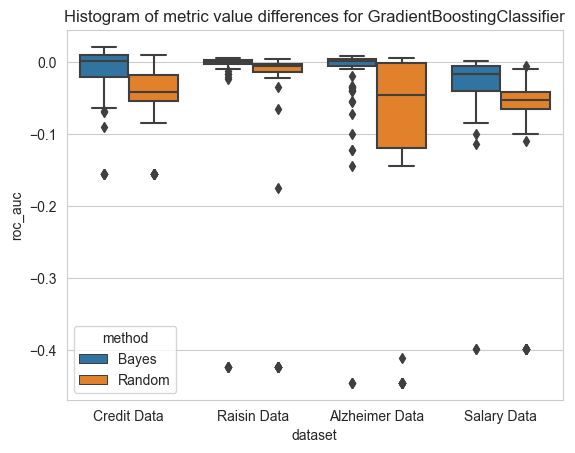

In [28]:
data = {
    'Credit Data': gbc_opt_results_bs[0].cv_results_["mean_test_score"]-default_score[0],
    'Raisin Data': gbc_opt_results_bs[1].cv_results_["mean_test_score"]-default_score[1],
    'Alzheimer Data': gbc_opt_results_bs[2].cv_results_["mean_test_score"]-default_score[2],
    'Salary Data': gbc_opt_results_bs[3].cv_results_["mean_test_score"]-default_score[3]
}
data_random = {
    'Credit Data': gbc_opt_results_rs[0].cv_results_["mean_test_score"]-default_score[0],
    'Raisin Data': gbc_opt_results_rs[1].cv_results_["mean_test_score"]-default_score[1],
    'Alzheimer Data': gbc_opt_results_rs[2].cv_results_["mean_test_score"]-default_score[2],
    'Salary Data': gbc_opt_results_rs[3].cv_results_["mean_test_score"]-default_score[3]
} 
data = pd.DataFrame(data)
data_random = pd.DataFrame(data_random)
# connect datasets data and data_random, adding column with method Random and Bayes 
data['method'] = 'Bayes'
data_random['method'] = 'Random'
data = pd.concat([data, data_random])
data = data.melt(id_vars='method', var_name='dataset', value_name='roc_auc')

sns.boxplot(x='dataset', y='roc_auc', hue='method', data=data)
plt.title('Histogram of metric value differences for GradientBoostingClassifier')
plt.show()